In [79]:
import json
import pandas as pd
import numpy as np
import random
from bidict import bidict
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from itertools import chain
from collections import Counter
import re
from nltk.corpus import stopwords

In [2]:
%matplotlib inline

In [3]:
sns.set(style="darkgrid", color_codes=True)
plt.style.use('ggplot')

In [4]:
df = pd.read_pickle("/data/rali7/Tmp/solimanz/data/pickles/clean_aug.pkl")

#with open("/data/rali7/Tmp/solimanz/data/pickles/test_ids.pkl", "rb") as f:
#    test_ids = pickle.load(f)
#with open("/data/rali7/Tmp/solimanz/data/pickles/train_ids.pkl", "rb") as f:
#    test_ids = pickle.load(f)

In [5]:
industries_dist = df.industry.value_counts(normalize=True)

In [5]:
func_counts = df.transformed.value_counts(normalize=True)

In [46]:
all_ids = df._id.unique()
bad_ids = df[~df.transformed.isin(func_count.index[:550])]._id.unique()
filtered_df = df[~df._id.isin(bad_ids)]

In [47]:
filtered_counts = filtered_df.transformed.value_counts(normalize=True)

In [6]:
plt.rcParams['figure.figsize'] = 10, 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlepad'] = 25

### Distribution of job titles by considering top 550 titles and all industries

Text(0.5,1,'freq. of job titles')

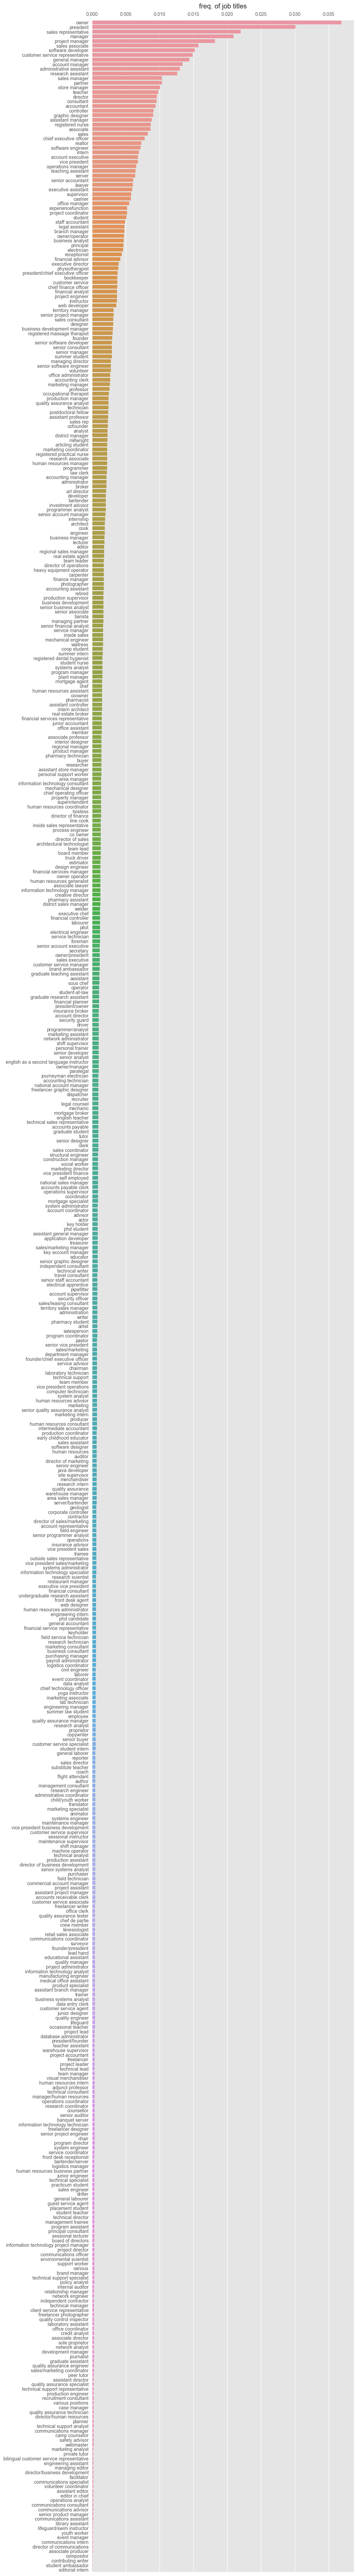

In [63]:
ax = sns.barplot(x=filtered_counts.values, y=filtered_counts.index.values, label='freq. of job titles', log=False)
#plt.setp(ax.get_xticklabels(), rotation=90)
ax.xaxis.tick_top()
ax.set_title("freq. of job titles")

In [7]:
sum(industries_dist.values[:80])

0.90882957346403226

$90\%$ of profiles are working in the top 80 industries $\approx 50\%$ of all industries available

In [9]:
df[df.industry.isin(industries_dist.index[:50])]._id.nunique()

1800662

In [10]:
filtered_df = df[df.industry.isin(industries_dist.index[:50])]

In [11]:
func_dist = filtered_df.transformed.value_counts(normalize=True) * 100

# Explore Distribution of Job Transitions

In [ ]:
grouped = df.groupby("_id")

In [ ]:
job_seqs = grouped.function.apply(lambda x: list(reversed(list(x))))

In [ ]:
transitions = job_seqs.apply(lambda x: list(zip(x, x[1:])))

In [ ]:
transitions = chain.from_iterable(transitions.values)

In [ ]:
transition_count = Counter(transitions)

In [ ]:
total_transitions = sum(transition_count.values())

In [ ]:
total_transitions

In [ ]:
title_id_mapping = bidict({title: i for i, title in enumerate(func_count.index.values)})

In [ ]:
transition_matrix = np.zeros((550,550), dtype=np.float32)
for (x,y), c in transition_count.items():
    transition_matrix[title_id_mapping[x], title_id_mapping[y]] = c / total_transitions    

In [ ]:
freqs = {str(key): (val/total_transitions) for key, val in transition_count.items()}

In [ ]:
pd.Series(freqs).sort_values(ascending=False)

In [ ]:
func_counts = df[df.transformed.isin(func_counts.index[:550])].transformed

In [18]:
joined = " ".join(func_counts.index.values)
tokens = re.split(r"[-/,\.\\\s]", joined)
token_counts = Counter(tokens)

In [165]:
del token_counts['']
del token_counts[':']

In [166]:
to_remove = stopwords.words('english')

In [167]:
for w in to_remove:
    if w in token_counts:
        del token_counts[w]

In [168]:
total = sum(token_counts.values())

In [169]:
normalized_tokens_count = Counter({k:100*(v/total) for k, v in token_counts.items()})

In [170]:
size = len(token_counts)

In [171]:
size

180954

In [172]:
values = np.array(sorted(normalized_tokens_count.values(), reverse=True))

In [173]:
x = np.arange(1, size, dtype=np.int32)
y = [np.sum(values[:i]) for i in x]

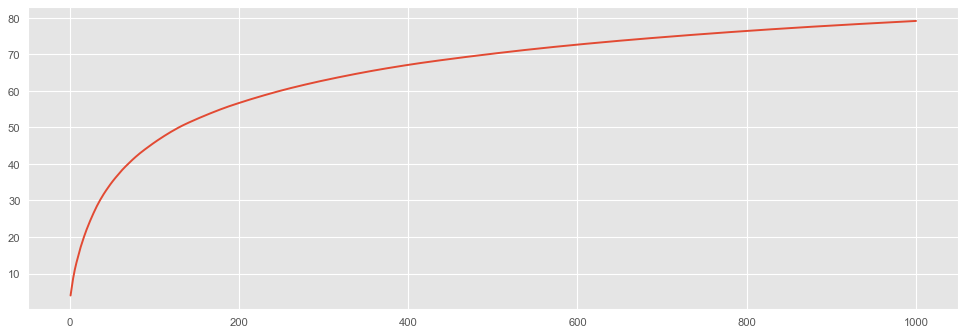

In [174]:
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['figure.dpi'] = 80
plt.plot(x[:1000], y[:1000])

In [178]:
tokens = token_counts.most_common(1000)
values = {k: v for k, v in tokens}
tokens = [t[0] for t in tokens]

We try to transform job titles into combinations of available tokens and see what happens

In [202]:
def transform(s, tokens, values):
    split = re.split(r"[-/,\.\\\s]", s)
    return '/'.join(sorted(filter(lambda x: x in tokens, split), key=lambda x: values[x]))

In [208]:
applied = df.transformed.apply(transform, args=(tokens, values))

In [212]:
df['token_trans'] = applied

In [214]:
df.token_trans.nunique()

1656843

In [215]:
df.transformed.nunique()

3161930

In [216]:
df.function.nunique()

3502165

In [218]:
func_dist = df.token_trans.value_counts(normalize=True) * 100

In [230]:
x2 = np.arange(1, 100000, dtype=np.int32)
y2 = [np.sum(func_dist.values[:i]) for i in x2]

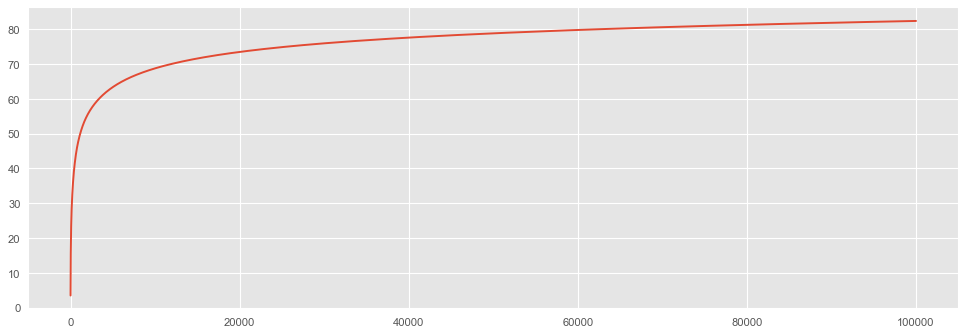

In [232]:
plt.plot(x2[:], y2[:])

In [ ]:
df.to_pickle("/data/rali7/Tmp/solimanz/data/pickles/add_tok_trans.pkl")